In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
df = pd.read_csv('dataset/train.csv')
df = df.drop(columns='id')

count    20758.000000
mean        30.241842
std          8.333932
min         12.868541
25%         24.088223
50%         29.384757
75%         37.011168
max         54.997991
Name: BMI, dtype: float64

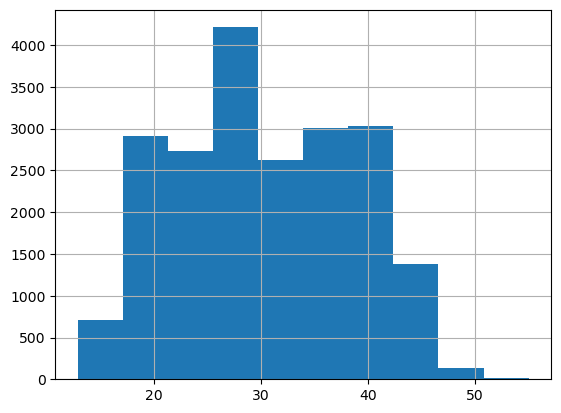

In [5]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'].hist()
df['BMI'].describe()

In [8]:
df['Age'].describe()

count    20758.000000
mean        23.841804
std          5.688072
min         14.000000
25%         20.000000
50%         22.815416
75%         26.000000
max         61.000000
Name: Age, dtype: float64

In [9]:
df[df['Age'] < 20].head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,16.861932
8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I,24.221453
12,Male,18.000000,1.811189,108.251044,yes,yes,2.000000,2.164839,Sometimes,no,2.530157,no,1.000000,0.553311,no,Public_Transportation,Obesity_Type_I,32.999286


In [27]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['BMI Predictions'] = np.select(conditions, values)

In [28]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,True,overweight
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,False,N/A
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,False,N/A
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,True,obseity class 3
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,True,overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084,True,obseity class 2
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278,False,N/A
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841,True,obseity class 1
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693,True,overweight


In [29]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.10 Mb (33.7% reduction)
memory GB:0.34
Memory reduced


features obtained


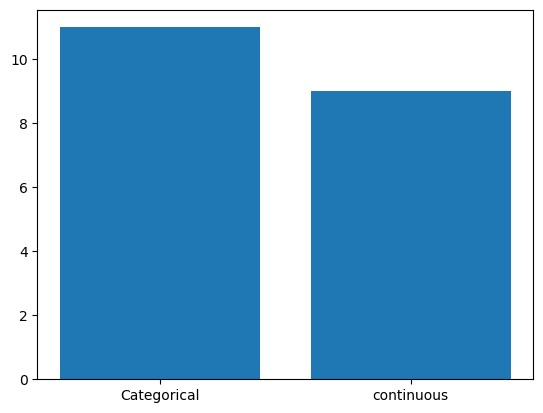

CPU times: total: 62.5 ms
Wall time: 86.2 ms


In [30]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [31]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', df_lean.shape)
# print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (df_lean.isnull().values.sum())
# test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/df_lean.shape[0]))
# print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(df_lean.info(),'\n')
# print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column #,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (20758, 20)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  11
Continuous features :  9
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 n

In [32]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

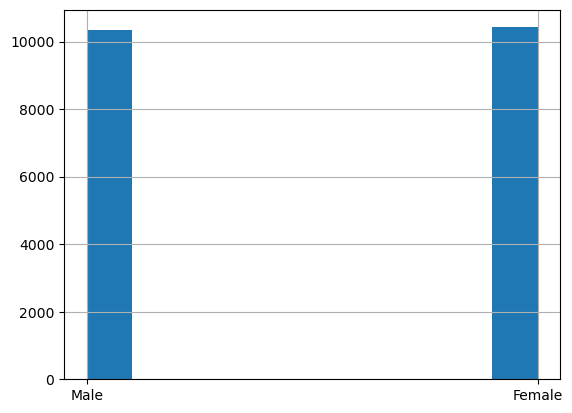

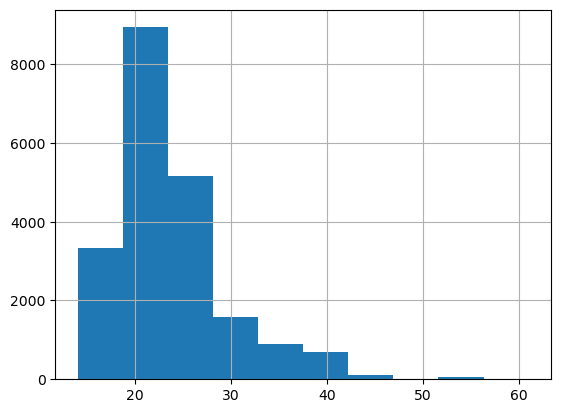

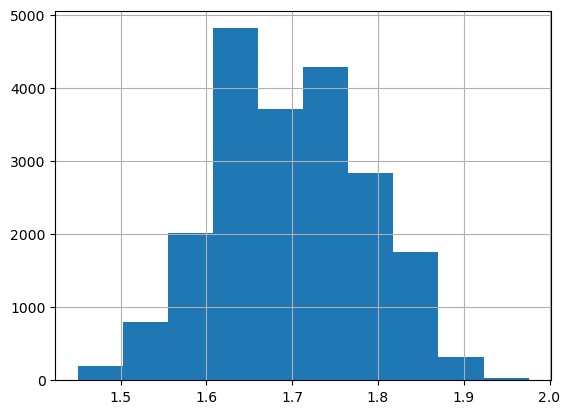

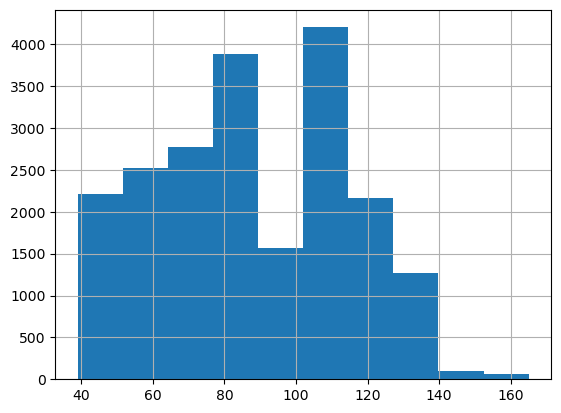

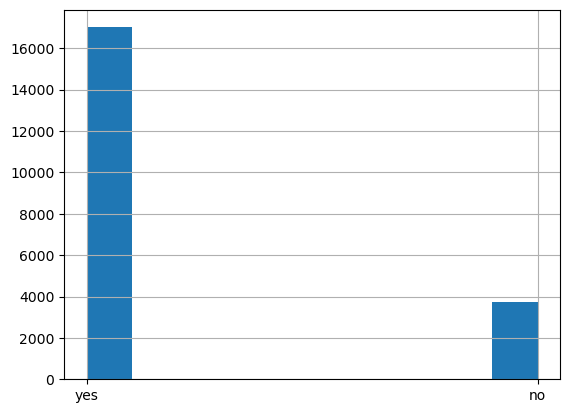

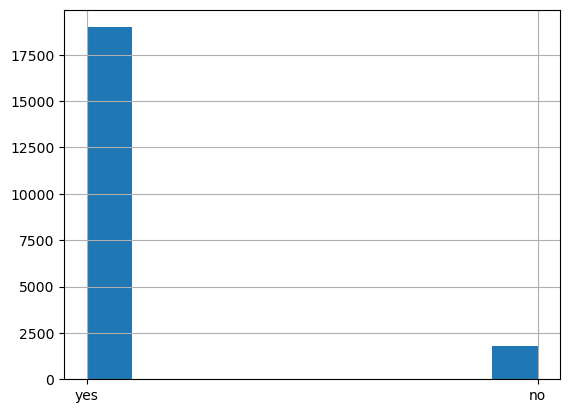

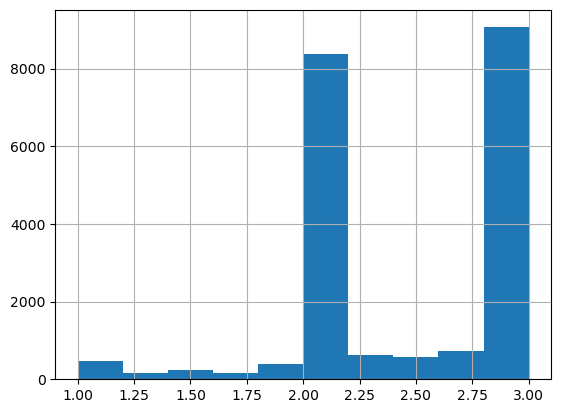

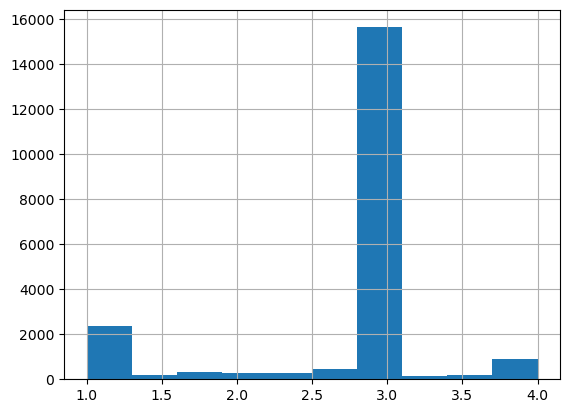

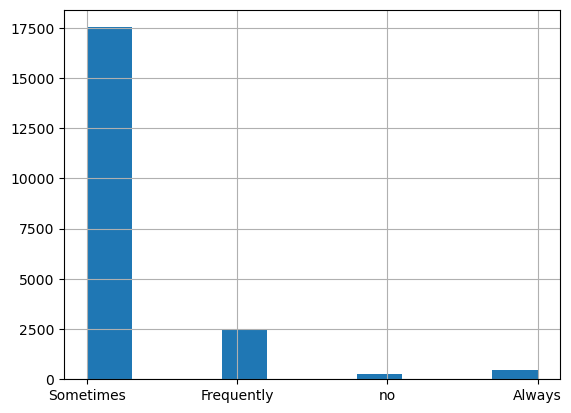

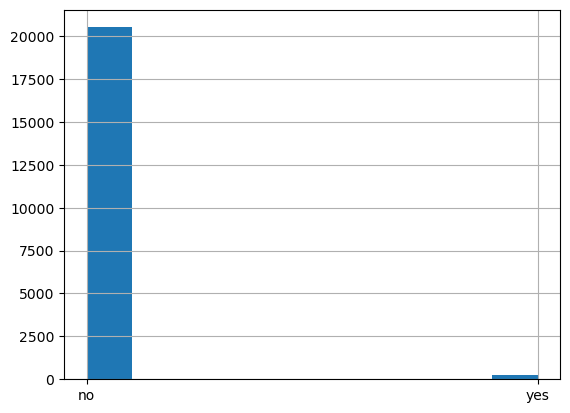

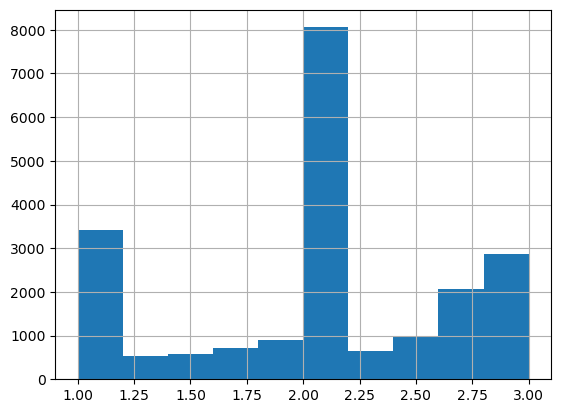

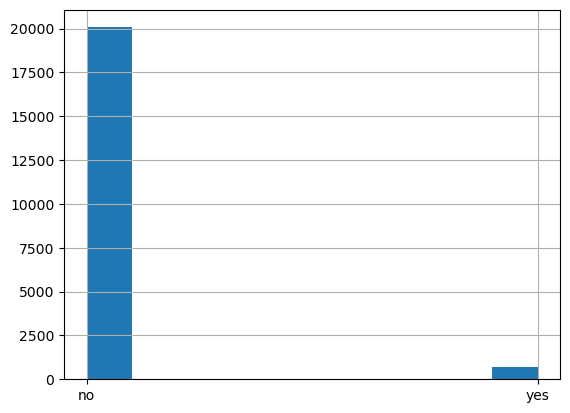

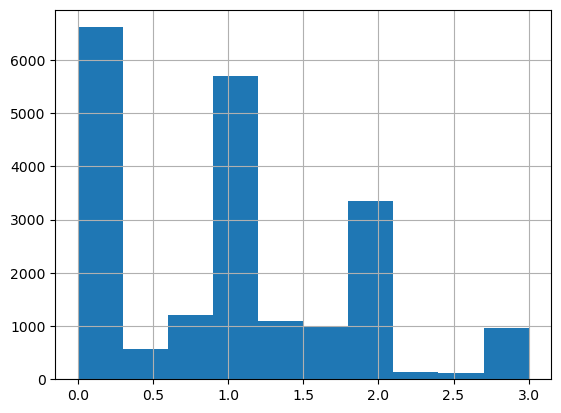

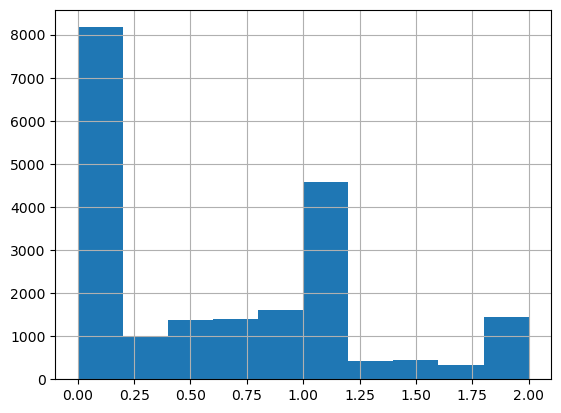

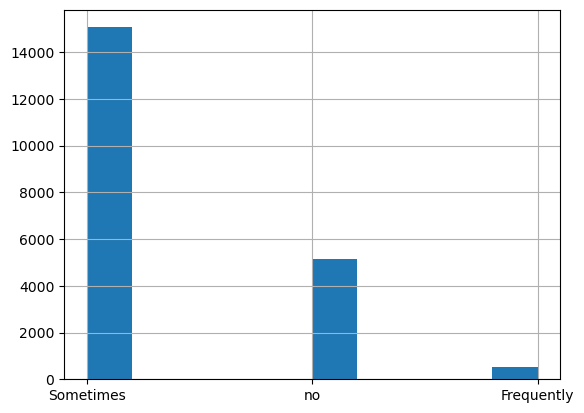

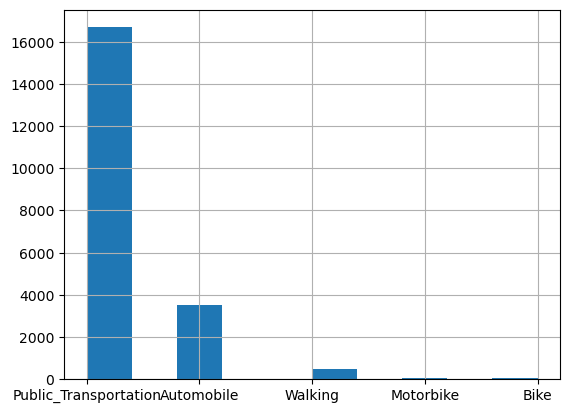

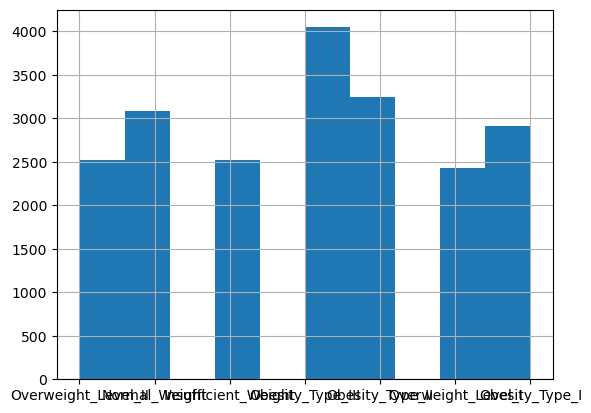

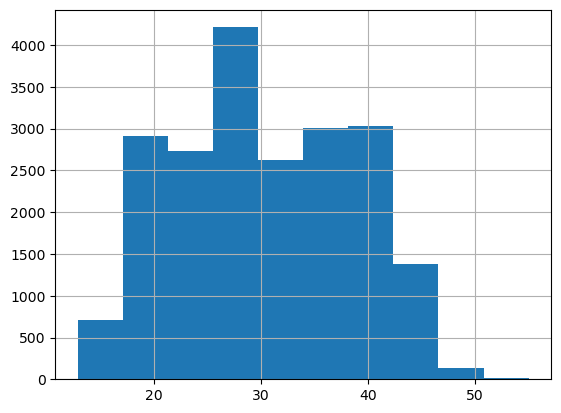

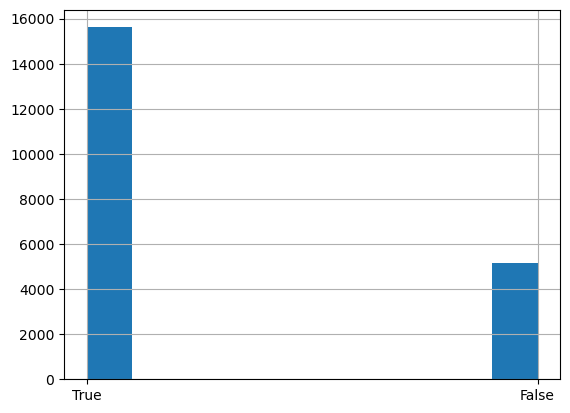

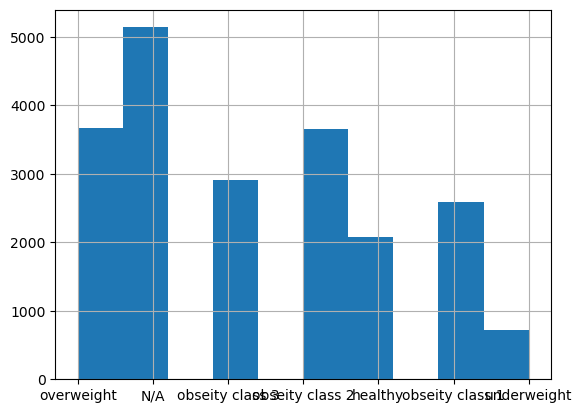

In [33]:
for col in df.columns:
    df[col].hist()
    plt.show()

ValueError: could not convert string to float: 'Male'

In [42]:
GaussianMixture().fit_predict(X)

ValueError: could not convert string to float: 'Male'